In [ ]:
# ============================================================
# Section 1 - Imports and Global Configuration
# ============================================================

import os
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, average_precision_score

# Directory for processed artifacts
PROCESSED_DIR = "processed"
os.makedirs(PROCESSED_DIR, exist_ok=True)

# Cleaned CSV filename
CLEAN_CSV = "Dataset_clean.csv"

# Downsampling threshold (None = no downsampling)
TARGET_NONFRAUD = 200_000

In [ ]:
# ============================================================
# Section 2 - Dataset Acquisition (KaggleHub)
# ============================================================

import kagglehub

# Download dataset directly from Kaggle (cached automatically)
dataset_path = kagglehub.dataset_download("ealaxi/paysim1")

# Identify CSV file inside the downloaded dataset
csv_path = os.path.join(dataset_path, "PS_20174392719_1491204439457_log.csv")

# Load into DataFrame
df = pd.read_csv(csv_path, low_memory=False)

print("CSV loaded from:", csv_path)
print("Initial rows:", len(df))


Using Colab cache for faster access to the 'paysim1' dataset.
CSV loaded from: /kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv
Initial rows: 6362620


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
# ============================================================
# Section 3 - Select Relevant Columns & Keep Raw Step
# ============================================================

cols_keep = [
    "step", "type", "amount",
    "nameOrig", "oldbalanceOrg", "newbalanceOrig",
    "nameDest", "oldbalanceDest", "newbalanceDest",
    "isFraud", "isFlaggedFraud",
]
df = df[cols_keep].copy()



print("Columns kept:", df.columns.tolist())
print("Rows after selection:", len(df))


Columns kept: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
Rows after selection: 6362620


In [ ]:
# ============================================================
# Section 4 - Data Overview
# ============================================================

display(df.head())
print("\nDtypes:\n", df.dtypes)

print("\nTransaction type distribution:")
print(df["type"].value_counts())


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0



Dtypes:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Transaction type distribution:
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [ ]:
# ============================================================
# Section 5 - Missing Values Report
# ============================================================

missing_counts = df.isnull().sum()
missing_percent = 100 * missing_counts / len(df)

missing_report = pd.concat([missing_counts, missing_percent], axis=1)
missing_report.columns = ["missing_count", "missing_percent"]

display(missing_report.sort_values("missing_count", ascending=False))

cols_with_missing = missing_report[missing_report["missing_count"] > 0].index.tolist()

if cols_with_missing:
    display(df[df[cols_with_missing].isnull().any(axis=1)].head(20))
else:
    print("No missing values detected.")


,missing_count,missing_percent
step,0,0.0
type,0,0.0
amount,0,0.0
nameOrig,0,0.0
oldbalanceOrg,0,0.0
newbalanceOrig,0,0.0
nameDest,0,0.0
oldbalanceDest,0,0.0
newbalanceDest,0,0.0
isFraud,0,0.0


No missing values detected.


In [ ]:
# ============================================================
# Section 6 - Duplicates and Consistency Checks
# ============================================================

duplicate_count = df.duplicated().sum()
print("Exact duplicate rows:", duplicate_count)

neg_old_org = (pd.to_numeric(df["oldbalanceOrg"], errors="coerce") < 0).sum()
neg_old_dest = (pd.to_numeric(df["oldbalanceDest"], errors="coerce") < 0).sum()

print("Negative oldbalanceOrg:", neg_old_org)
print("Negative oldbalanceDest:", neg_old_dest)


Exact duplicate rows: 0
Negative oldbalanceOrg: 0
Negative oldbalanceDest: 0


In [ ]:
# ============================================================
# Section 7 - Cleaning: Numeric Coercion, Fill Missing, Remove Duplicates
# ============================================================

numeric_cols = [
    "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[numeric_cols] = df[numeric_cols].fillna(0)

df = df.drop_duplicates().reset_index(drop=True)

print("Rows after cleaning:", len(df))
print("Frauds:", df["isFraud"].sum())
print("Non-frauds:", (df["isFraud"] == 0).sum())


Rows after cleaning: 6362620
Frauds: 8213
Non-frauds: 6354407


In [ ]:
# ============================================================
# Section 8 - Downsample Non-Fraud (Keep All Frauds)
# ============================================================

if TARGET_NONFRAUD is None:
    print("Downsampling disabled.")
else:
    fraud_df = df[df["isFraud"] == 1]
    nonfraud_df = df[df["isFraud"] == 0]

    nonfraud_sample = nonfraud_df.sample(
        n=min(TARGET_NONFRAUD, len(nonfraud_df)),
        random_state=42
    )

    df = pd.concat([fraud_df, nonfraud_sample], axis=0)


    print("Rows after downsampling:", len(df))
    print("Frauds:", df["isFraud"].sum())
    print("Non-frauds:", (df["isFraud"] == 0).sum())

df.to_csv(CLEAN_CSV, index=False)
print("Saved cleaned CSV:", CLEAN_CSV)


Rows after downsampling: 208213
Frauds: 8213
Non-frauds: 200000
Saved cleaned CSV: Dataset_clean.csv


In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


In [ ]:
# ============================================================
# Section 9- Plot Outliers (Histogram + IQR thresholds)
# ============================================================

import matplotlib.pyplot as plt


numeric_cols = [
    "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

for i, col in enumerate(numeric_cols, 1):
    data = df[col]

    # Compute IQR boundaries
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR





=== BOXPLOTS FOR OUTLIERS ===


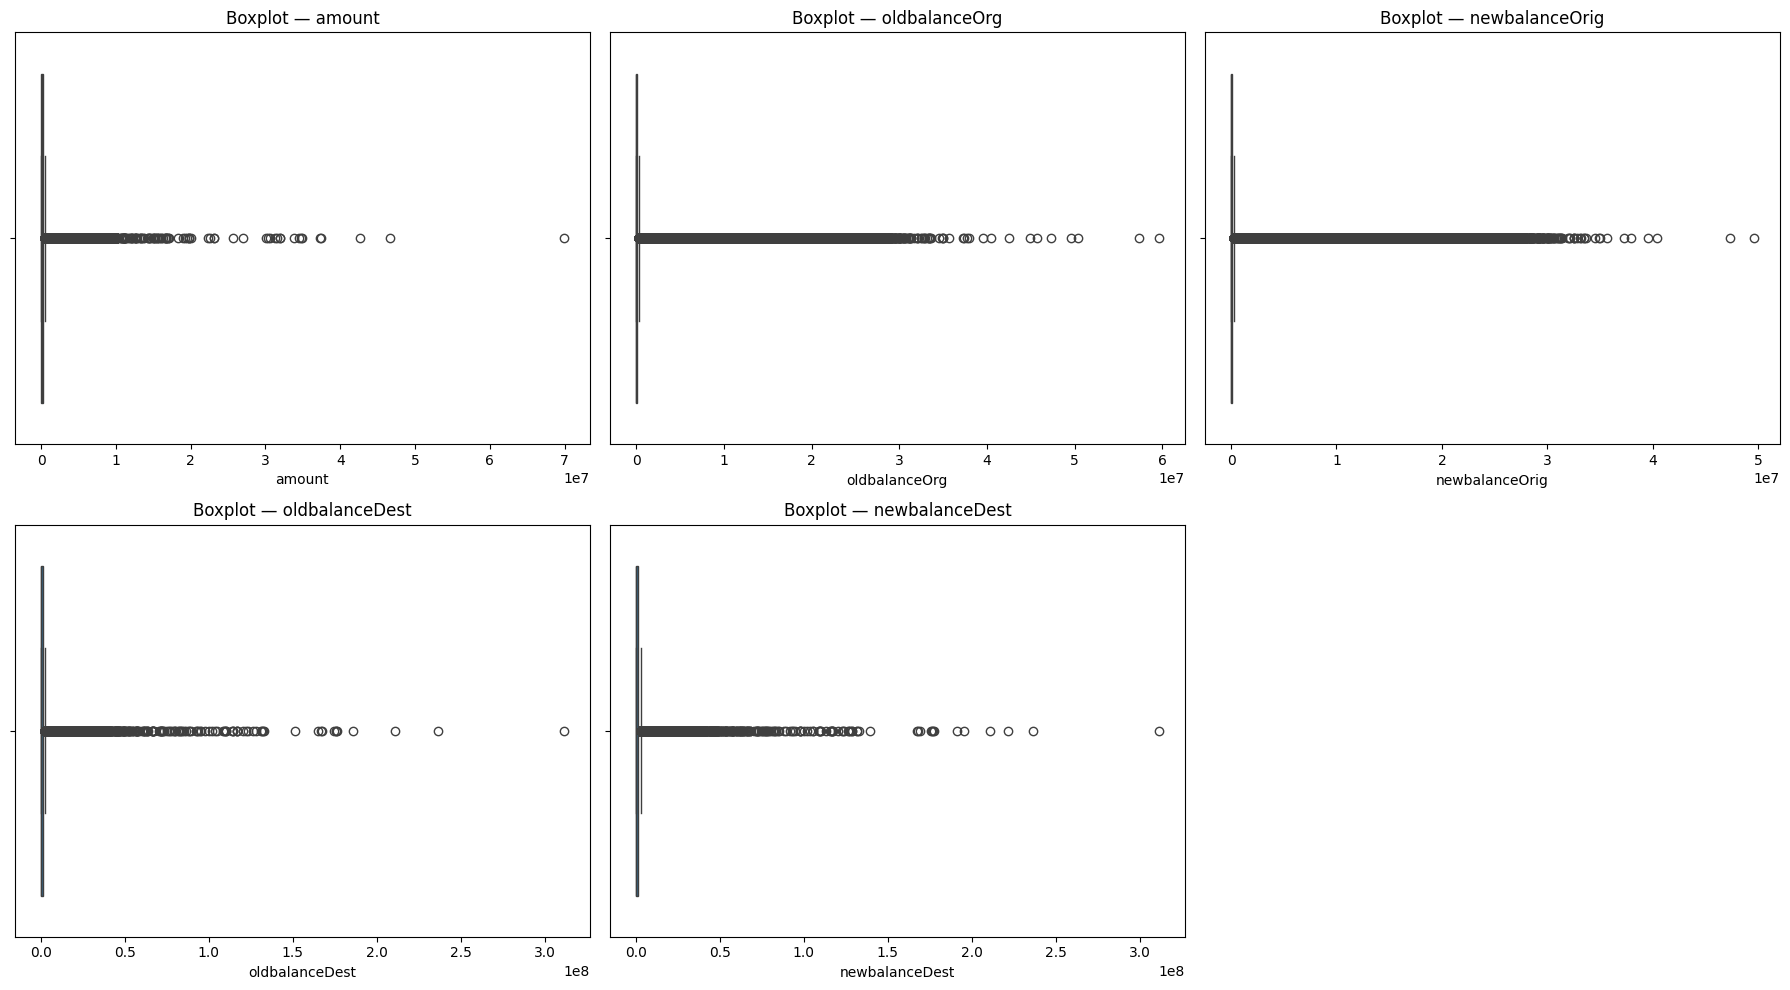

In [ ]:
# ============================================================
# Section 10 - Boxplots (Visual Outlier Detection)
# ============================================================

print("\n=== BOXPLOTS FOR OUTLIERS ===")

import seaborn as sns

plt.figure(figsize=(18, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot — {col}")

plt.tight_layout()
plt.show()


The boxplots above illustrate the distribution of the main numerical features
(amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest).

Each subplot shows extremely long whiskers and a very dense cluster near zero,
followed by many isolated points far to the right. These isolated points
represent strong outliers — unusually large transaction amounts or balances.

In [ ]:
# ============================================================
# Section 11 - Count Outliers Using IQR
# ============================================================

print("\n=== OUTLIER COUNTS (IQR METHOD) ===")

numeric_cols = [
    "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

for col in numeric_cols:

    data = df[col]

    # Compute quartiles and IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    percent = 100 * num_outliers / len(df)

    print(f"{col}: {num_outliers} outliers ({percent:.4f}%)")

print("\nDone.")



=== OUTLIER COUNTS (IQR METHOD) ===
amount: 13332 outliers (6.4031%)
oldbalanceOrg: 36454 outliers (17.5080%)
newbalanceOrig: 35201 outliers (16.9062%)
oldbalanceDest: 25793 outliers (12.3878%)
newbalanceDest: 24223 outliers (11.6338%)

Done.


In [ ]:
# Loop through each numerical column to handle outliers
for col in numeric_cols:

    # Compute the first quartile (25th percentile)
    Q1 = df[col].quantile(0.25)

    # Compute the third quartile (75th percentile)
    Q3 = df[col].quantile(0.75)

    # Calculate the Interquartile Range (IQR = Q3 - Q1)
    IQR = Q3 - Q1

    # Define the lower bound for acceptable values
    lower = Q1 - 1.5 * IQR

    # Define the upper bound for acceptable values
    upper = Q3 + 1.5 * IQR

    # Clip values outside the lower–upper range (winsorization)
    # Values below 'lower' become 'lower', values above 'upper' become 'upper'
    df[col] = df[col].clip(lower, upper)


In [ ]:
# ============================================================
# Section 12 - Count Outliers Using IQR
# ============================================================

print("\n=== OUTLIER COUNTS (IQR METHOD) ===")

numeric_cols = [
    "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

for col in numeric_cols:

    data = df[col]

    # Compute quartiles and IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    percent = 100 * num_outliers / len(df)

    print(f"{col}: {num_outliers} outliers ({percent:.4f}%)")

print("\nDone.")



=== OUTLIER COUNTS (IQR METHOD) ===
amount: 0 outliers (0.0000%)
oldbalanceOrg: 0 outliers (0.0000%)
newbalanceOrig: 0 outliers (0.0000%)
oldbalanceDest: 0 outliers (0.0000%)
newbalanceDest: 0 outliers (0.0000%)

Done.



=== BOXPLOTS FOR OUTLIERS ===


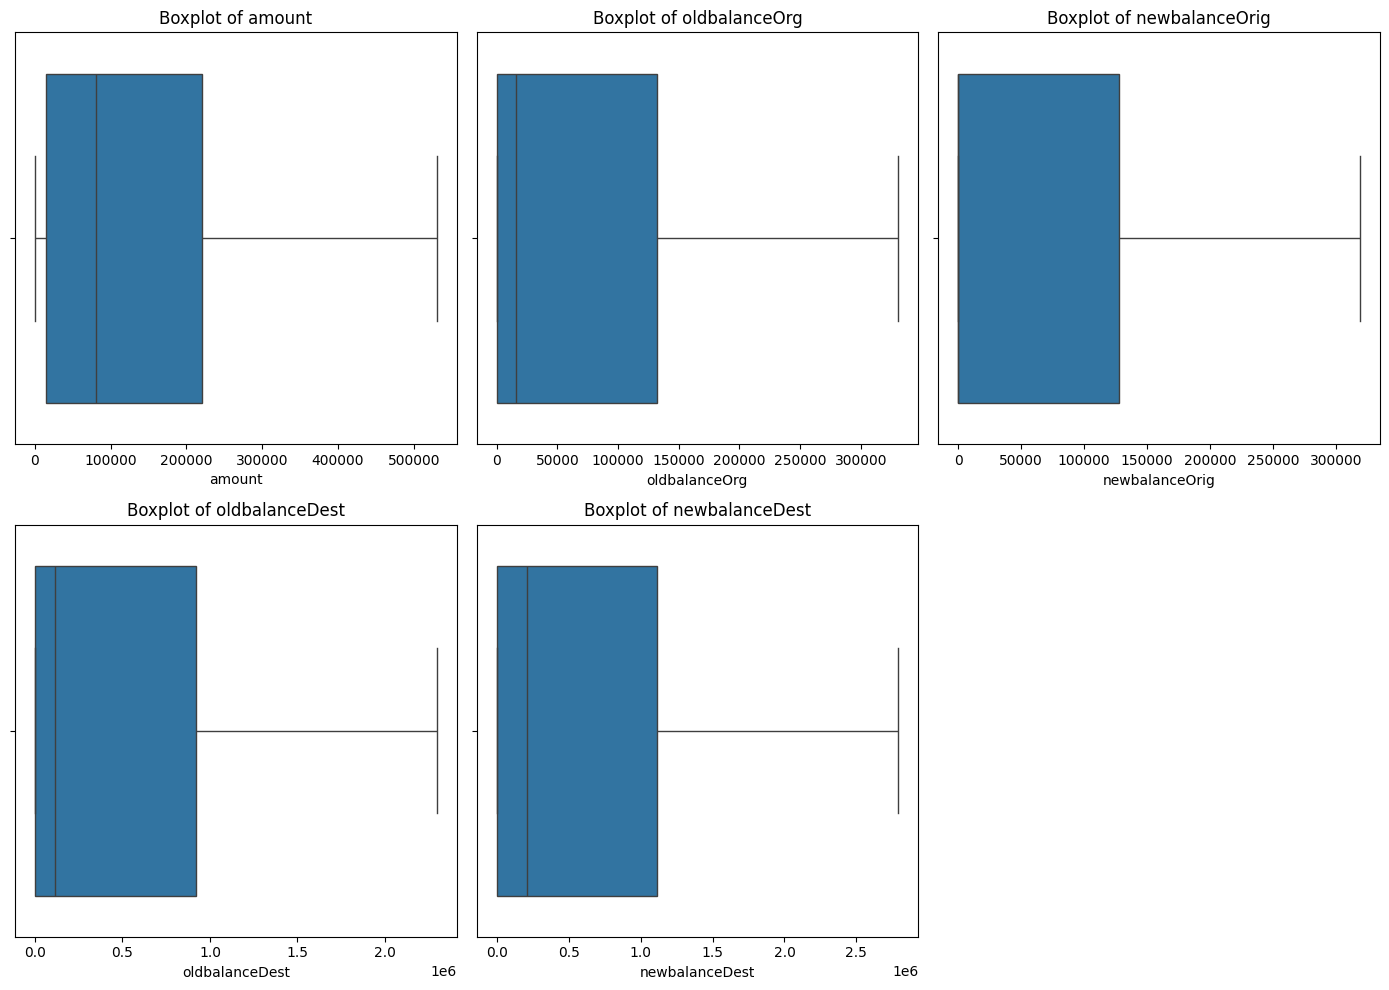

In [ ]:
# ============================================================
# Section 13 - Outlier Visualization (Boxplots)
# ============================================================

print("\n=== BOXPLOTS FOR OUTLIERS ===")

plt.figure(figsize=(14, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()


The boxplots above show the distribution of the numerical features
(amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest)
after applying IQR-based clipping to reduce extreme outliers.

Compared to the previous boxplots (before clipping), we observe the following:

• The extreme right-side outliers have been removed, indicating that the
  IQR clipping successfully limited unusually large transaction values.

• The boxplots now appear more compact and interpretable, with the interquartile
  ranges clearly visible instead of being compressed near zero.

• The whiskers extend to more reasonable values, showing that the numerical
  features no longer have extreme skew caused by rare, very large balances
  or transaction amounts.

Overall, this confirms that outlier handling has improved the distribution
of the data, making it more suitable for machine learning models and reducing
the influence of rare extreme values in the training process.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208213 entries, 2 to 3838822
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            208213 non-null  int64  
 1   type            208213 non-null  object 
 2   amount          208213 non-null  float64
 3   nameOrig        208213 non-null  object 
 4   oldbalanceOrg   208213 non-null  float64
 5   newbalanceOrig  208213 non-null  float64
 6   nameDest        208213 non-null  object 
 7   oldbalanceDest  208213 non-null  float64
 8   newbalanceDest  208213 non-null  float64
 9   isFraud         208213 non-null  int64  
 10  isFlaggedFraud  208213 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 19.1+ MB


In [ ]:
df.head(60)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,2790520.75,1,0
969,1,TRANSFER,530040.04,C1334405552,330762.50,0.0,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,530040.04,C467632528,330762.50,0.0,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0


In [ ]:
print(df['isFlaggedFraud'].value_counts())


isFlaggedFraud
0    208197
1        16
Name: count, dtype: int64


In [ ]:
df = df.drop(columns=["isFlaggedFraud"])
#Dropped the column isFlaggedFraud because it's too imbalanced

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208213 entries, 2 to 3838822
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            208213 non-null  int64  
 1   type            208213 non-null  object 
 2   amount          208213 non-null  float64
 3   nameOrig        208213 non-null  object 
 4   oldbalanceOrg   208213 non-null  float64
 5   newbalanceOrig  208213 non-null  float64
 6   nameDest        208213 non-null  object 
 7   oldbalanceDest  208213 non-null  float64
 8   newbalanceDest  208213 non-null  float64
 9   isFraud         208213 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 17.5+ MB


In [ ]:
print("Number of isFlaggedFraud cases:", df["isFraud"].sum())
print("Number of non-flagged transactions:", (df["isFraud"] == 0).sum())


Number of isFlaggedFraud cases: 8213
Number of non-flagged transactions: 200000


In [ ]:
# Define mapping
type_mapping = {
    "CASH_IN": 0,
    "CASH_OUT": 1,
    "DEBIT": 2,
    "PAYMENT": 3,
    "TRANSFER": 4
}

# Apply mapping
df["type"] = df["type"].map(type_mapping)

# Verify
print(df["type"].value_counts())


type
1    74367
3    67898
0    43742
4    20900
2     1306
Name: count, dtype: int64


In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,4,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
3,1,1,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
251,1,4,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
252,1,1,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
680,1,4,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


In [ ]:
df.describe()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,208213.000000,208213.000000,208213.000000,208213.000000,208213.000000,2.082130e+05,2.082130e+05,208213.000000
mean,248.444372,1.749521,142028.133808,88303.042207,78414.713233,5.813614e+05,7.162647e+05,0.039445
std,148.093240,1.364690,157851.964403,126380.691959,124320.254897,8.167642e+05,9.725277e+05,0.194652
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,156.000000,1.000000,14044.540000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
50%,250.000000,1.000000,80951.300000,16340.000000,0.000000,1.132758e+05,2.079291e+05,0.000000
75%,347.000000,3.000000,220442.740000,132305.000000,127646.160000,9.178712e+05,1.116208e+06,0.000000
max,743.000000,4.000000,530040.040000,330762.500000,319115.400000,2.294678e+06,2.790521e+06,1.000000


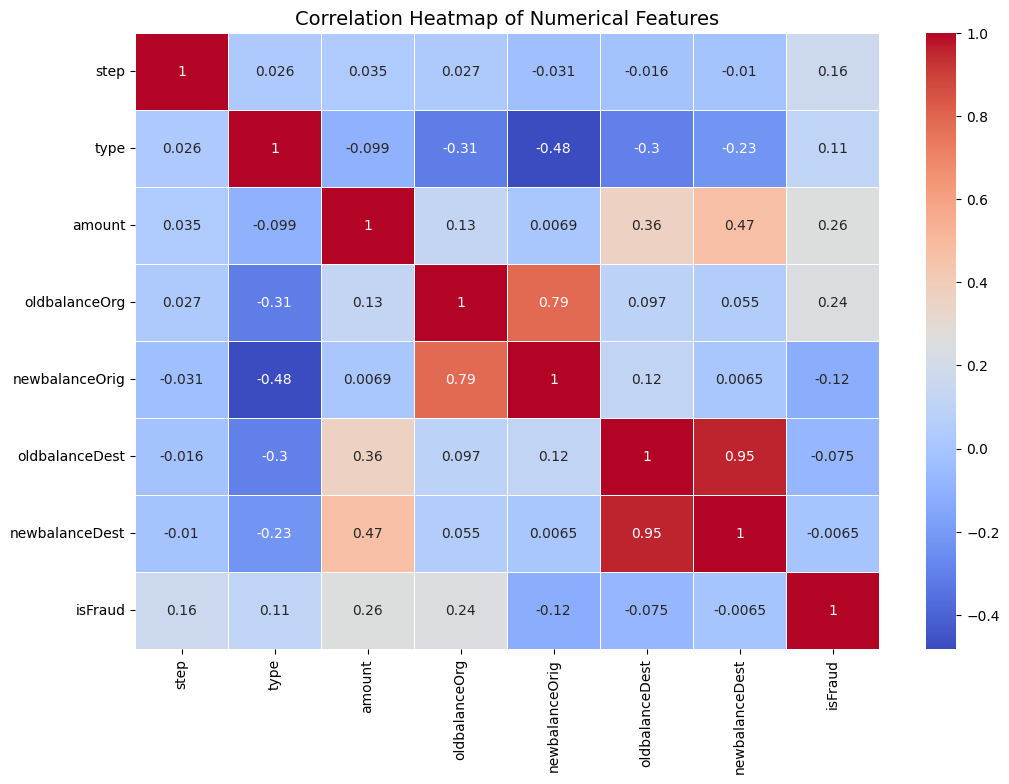

In [ ]:
plt.figure(figsize=(12, 8))

corr_matrix = df.corr(numeric_only=True)

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.show()


Strong Positive Correlations

oldbalanceDest and newbalanceDest (~0.95):
Very strongly correlated — the final destination balance is closely tied to the initial balance.

oldbalanceOrg and newbalanceOrig (~0.79):
Very strongly correlated  — the final origin balance strongly depends on the initial balance.

amount and destination balances (~0.36–0.47):
Higher transaction amounts often result in larger changes in destination balances.

Correlation with Target (isFraud)

isFraud has weak correlations with most features, though:

step (0.16) and amount (0.26) show small positive relationships.

oldbalanceOrg (~0.24) also shows slight correlation.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ----------------------------
# 1️⃣ Define features and target
# ----------------------------
# Drop non-feature columns (like names, step_raw can be used optionally)
X = df.drop(columns=["isFraud", "nameOrig", "nameDest"])
y = df["isFraud"]

# Identify numeric features for scaling
numeric_cols = [
    "step", "type", "amount", "oldbalanceOrg", "newbalanceOrig",
    "oldbalanceDest", "newbalanceDest"
]

# ----------------------------
# 2️⃣ Split dataset
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set:", X_train.shape, "Testing set:", X_test.shape)
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())

# ----------------------------
# 3️⃣ Feature scaling
# ----------------------------
scaler = StandardScaler()

# Fit scaler only on training set
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Apply same transformation to test set
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ----------------------------
# 4️⃣ Optional: Verify scaling
# ----------------------------
print("\nFeature scaling summary (train set):")
print(pd.DataFrame(X_train[numeric_cols]).describe())


Training set: (166570, 7) Testing set: (41643, 7)
Fraud ratio in train: 0.039442876868583776
Fraud ratio in test: 0.03945441010493961

Feature scaling summary (train set):
               step          type        amount  oldbalanceOrg  \
count  1.665700e+05  1.665700e+05  1.665700e+05   1.665700e+05   
mean   6.720658e-17  1.962236e-18 -1.180754e-16  -4.820276e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00   1.000003e+00   
min   -1.671351e+00 -1.283142e+00 -8.995361e-01  -6.983164e-01   
25%   -6.245109e-01 -5.498890e-01 -8.104366e-01  -6.983164e-01   
50%    1.034698e-02 -5.498890e-01 -3.870305e-01  -5.688124e-01   
75%    6.654662e-01  9.166167e-01  4.979796e-01   3.445640e-01   
max    3.339974e+00  1.649869e+00  2.463371e+00   1.920444e+00   

       newbalanceOrig  oldbalanceDest  newbalanceDest  
count    1.665700e+05    1.665700e+05    1.665700e+05  
mean     1.151321e-16    8.655167e-17    8.032371e-17  
std      1.000003e+00    1.000003e+00    1.000003e+00  
min     -

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 208213 entries, 2 to 3838822
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            208213 non-null  int64  
 1   type            208213 non-null  int64  
 2   amount          208213 non-null  float64
 3   nameOrig        208213 non-null  object 
 4   oldbalanceOrg   208213 non-null  float64
 5   newbalanceOrig  208213 non-null  float64
 6   nameDest        208213 non-null  object 
 7   oldbalanceDest  208213 non-null  float64
 8   newbalanceDest  208213 non-null  float64
 9   isFraud         208213 non-null  int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 17.5+ MB


In [ ]:
# ----------------------------
# 1️⃣ Install libraries if needed
# ----------------------------
# !pip install xgboost lightgbm --quiet

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, average_precision_score, accuracy_score

# ----------------------------
# 2️⃣ Initialize models
# ----------------------------
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=100, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(), use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42, n_estimators=100, class_weight='balanced')
}

# ----------------------------
# 3️⃣ Train and evaluate models
# ----------------------------
results = []

for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    avg_prec = average_precision_score(y_test, y_prob)
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (Fraud)": report['1']['precision'],
        "Recall (Fraud)": report['1']['recall'],
        "F1 (Fraud)": report['1']['f1-score'],
        "Average Precision": avg_prec
    })

    print(classification_report(y_test, y_pred, digits=4))
    print(f"Accuracy: {acc:.4f} | Average Precision: {avg_prec:.4f}")

# ----------------------------
# 4️⃣ Summary table
# ----------------------------
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)



=== Training Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9948    0.9604    0.9773     40000
           1     0.4764    0.8771    0.6174      1643

    accuracy                         0.9571     41643
   macro avg     0.7356    0.9187    0.7973     41643
weighted avg     0.9743    0.9571    0.9631     41643

Accuracy: 0.9571 | Average Precision: 0.7995

=== Training Random Forest ===
              precision    recall  f1-score   support

           0     0.9970    0.9993    0.9981     40000
           1     0.9819    0.9264    0.9533      1643

    accuracy                         0.9964     41643
   macro avg     0.9895    0.9628    0.9757     41643
weighted avg     0.9964    0.9964    0.9964     41643

Accuracy: 0.9964 | Average Precision: 0.9925

=== Training XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:29:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0     0.9997    0.9978    0.9987     40000
           1     0.9478    0.9939    0.9703      1643

    accuracy                         0.9976     41643
   macro avg     0.9738    0.9958    0.9845     41643
weighted avg     0.9977    0.9976    0.9976     41643

Accuracy: 0.9976 | Average Precision: 0.9953

=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 6570, number of negative: 160000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1536
[LightGBM] [Info] Number of data points in the train set: 166570, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score  

,Model,Accuracy,Precision (Fraud),Recall (Fraud),F1 (Fraud),Average Precision
0,Logistic Regression,0.957112,0.476364,0.877054,0.617395,0.799511
1,Random Forest,0.996422,0.981935,0.926354,0.953335,0.992453
2,XGBoost,0.997599,0.947766,0.993914,0.970291,0.995348
3,LightGBM,0.996350,0.919527,0.994522,0.955556,0.991710


**-Logistic Regression:**

Strengths:

Good overall accuracy (95.7%).

Very high recall for fraud (87.7%), meaning it detects most fraud cases.

Weaknesses:

Very low precision (47.6%): almost half of the fraud predictions are false alarms.

F1-score is moderate (61.7%).

Interpretation:
Logistic Regression is simple and fast, but struggles with precision in highly imbalanced fraud data.


**-Random Forest:**

Strengths:

Excellent accuracy (99.64%).

Very high fraud precision (98.1%) and strong recall (92.6%).

High fraud F1-score (95.3%).

Interpretation:
Random Forest performs extremely well across all metrics, providing a good balance between catching fraud and minimizing false positives.

**-XGBoost:**

Strengths:

Highest accuracy (99.76%) among the models.

Outstanding recall for fraud (99.39%) — it catches almost all fraud.

Very strong precision (94.8%) and F1-score (97.0%).

Best Average Precision (0.9953).

Interpretation:
XGBoost provides the best combination of precision, recall, and overall robustness.
It is the strongest performer for fraud detection in this dataset.

**-LightGBM:**

Strengths:

Very high accuracy (99.63%).

Excellent recall for fraud (99.45%) — almost all fraud is identified.

Strong precision (91.9%) and F1-score (95.6%).

Weaknesses:

Slightly weaker precision compared to Random Forest and XGBoost.

Interpretation:
LightGBM is extremely competitive and nearly matches XGBoost, especially in recall.

**-Final Conclusion:**

Among the four models:

XGBoost is the best-performing model overall

It achieves the highest accuracy, near-perfect recall, and the best balanced F1-score for fraud cases.